In [1]:
using Revise

In [2]:
using QuantumStates
using
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ

_μB = (μ_B / h) * 1e-4

include("CaOH_package.jl")
include("stochastic_schrodinger_diffusion.jl")
include("stochastic_schrodinger_constant_diffusion.jl")
include("monte_carlo_diffusion.jl")
include("monte_carlo_constant_diffusion.jl")
include("analyze_results.jl")
include("helper_functions.jl")
include("load_save_results.jl")
;

In [3]:
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

In [32]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -75 * 0; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 52.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

r1 = 3.7
r3 = 2.8 
r2 = 3.5

# r1 = 1
# r3 = 0.5
# r2 = 0

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0

s1 = 1
s2 = 1

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.21)
;

In [33]:
~,diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 2e-4, diameter=200e-6);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


In [34]:
diffusion_constant

0.1815663609968313

In [35]:
blue_MOT_params.diffusion_constant = diffusion_constant
blue_MOT_params.n_values = 100
sequence = [blue_MOT_params]
durations = [2e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:   2%|█                                        |  ETA: 0:01:21┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:   3%|██                                       |  ETA: 0:01:19┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:   4%|██                                       |  ETA: 0:01:23┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integ

868.467949 seconds (1.46 M allocations: 237.552 MiB, 0.00% gc time, 1.71% compilation time)


In [36]:
bootstrap_temperature_fit(results,2;iter=100)

(109.2859258406771, 20.766438833105493)

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


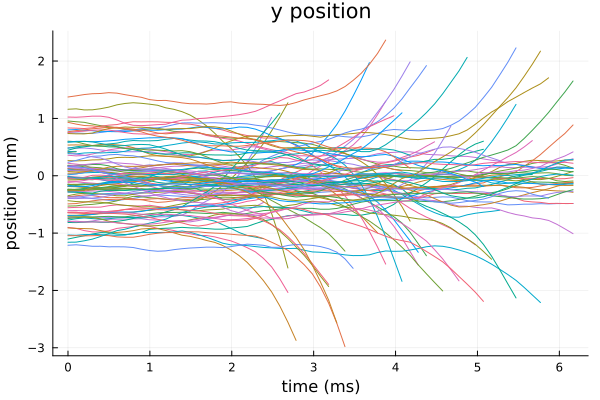

In [11]:
plot_all_trajectories(results, "y")
plot!()

In [21]:
bootstrap_size_fit(results,5;iter=100)

(0.05227769178279342, 0.011185823996315602)

In [22]:
bootstrap_temperature_fit(results,5;iter=100)

(143.90393150643794, 40.568366668179955)

In [91]:
ts_2 = 0.1:0.5:15
sizes_2 = Float64[]
errors_2 = Float64[]
for t in ts_2
    size, error = bootstrap_size_fit(results, t; iter=100, range=1.0)
    push!(sizes_2, size)
    push!(errors_2, error)
end

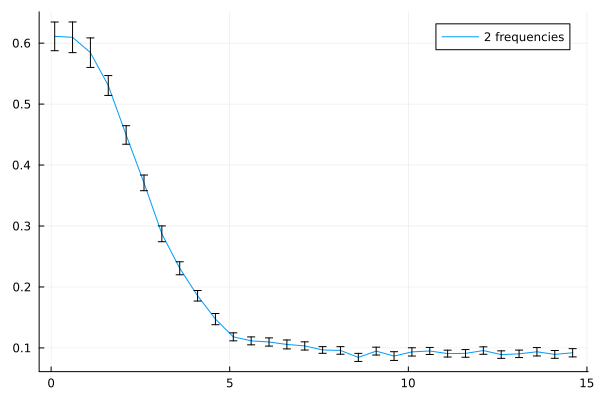

In [92]:
plot(ts_2, sizes_2, yerr=errors_2, label="2 frequencies")

In [14]:
ts_2 = 0.1:0.5:5
numbers_2 = Float64[]
n_errors_2 = Float64[]
for t in ts_2
    n, error = bootstrap_survival(results, t, rmax=4.0)
    push!(numbers_2, n)
    push!(n_errors_2, error)
end

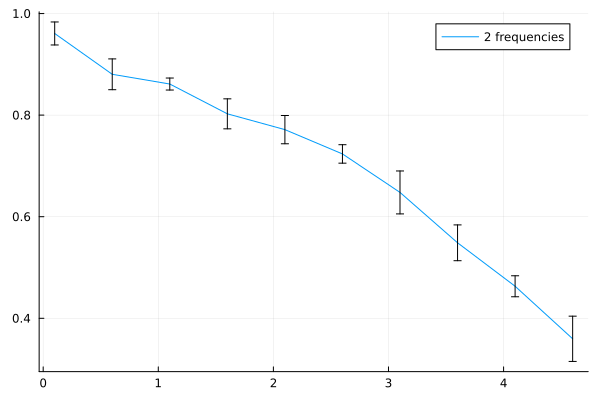

In [15]:
 plot(ts_2, numbers_2, yerr=n_errors_2, label="2 frequencies")

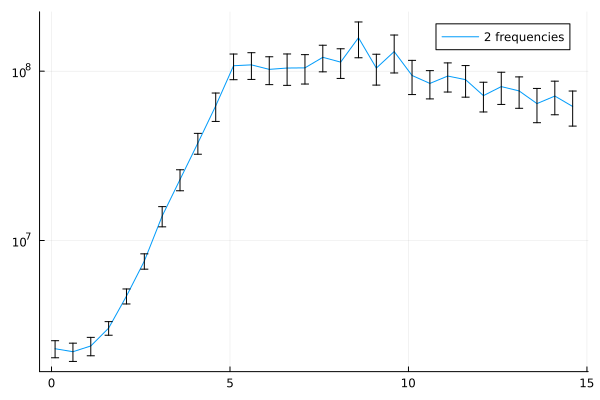

In [96]:
units = 1e3 * 5000/0.6

densities_2 = numbers_2./sizes_2.^3 * units / (2π)^(3/2)

density_error_2 = sqrt.((n_errors_2./sizes_2.^3).^2 + (3 .*errors_2.*numbers_2./sizes_2.^4).^2)* units / (2π)^(3/2)


plot(ts_2, densities_2,yerr=density_error_2, label="2 frequencies")
plot!(yscale=:log)

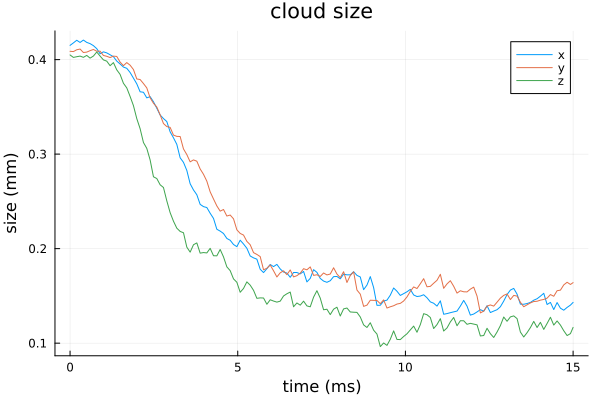

In [95]:
plot_size(results,"all")
plot!()

0.5230203101351178


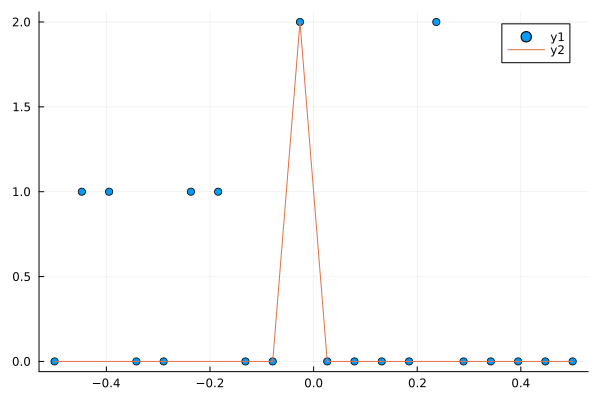

In [82]:
n_values = 100
t_end = 15e-3

sizes = []
x_grid = collect(LinRange(-0.5, 0.5, 20))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived(t_end, results.times)

xs = [results1.z_velocities[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

# println(fit.param[2])
# println(plot_size(results1, "x")[2][end])
    println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

In [84]:
bootstrap_size_fit(results; iter=100, range=0.2)

LoadError: DomainError with -2.392841513263821e-7:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [71]:
bootstrap_temperature_fit(results; iter=100, range=0.5,n_grids=20)

(290.7668170267661, 144.6954435656145)

In [110]:
log_test_info("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans",1,blue_MOT_params)

1

In [111]:
save_results("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans",1,results)

In [7]:
results1 = load_results("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans",1);

In [6]:
using Serialization
function load_results(saving_dir, test_i)
    folder = @sprintf("test%d", test_i)
    folder_dir = joinpath(saving_dir, folder)
    if isdir(folder_dir)==false
        @printf("%s is not found.", folder_dir)
        println()
       return nothing 
    end
    results = deserialize(joinpath(folder_dir, "results.jl"))
    return results
end

load_results (generic function with 1 method)

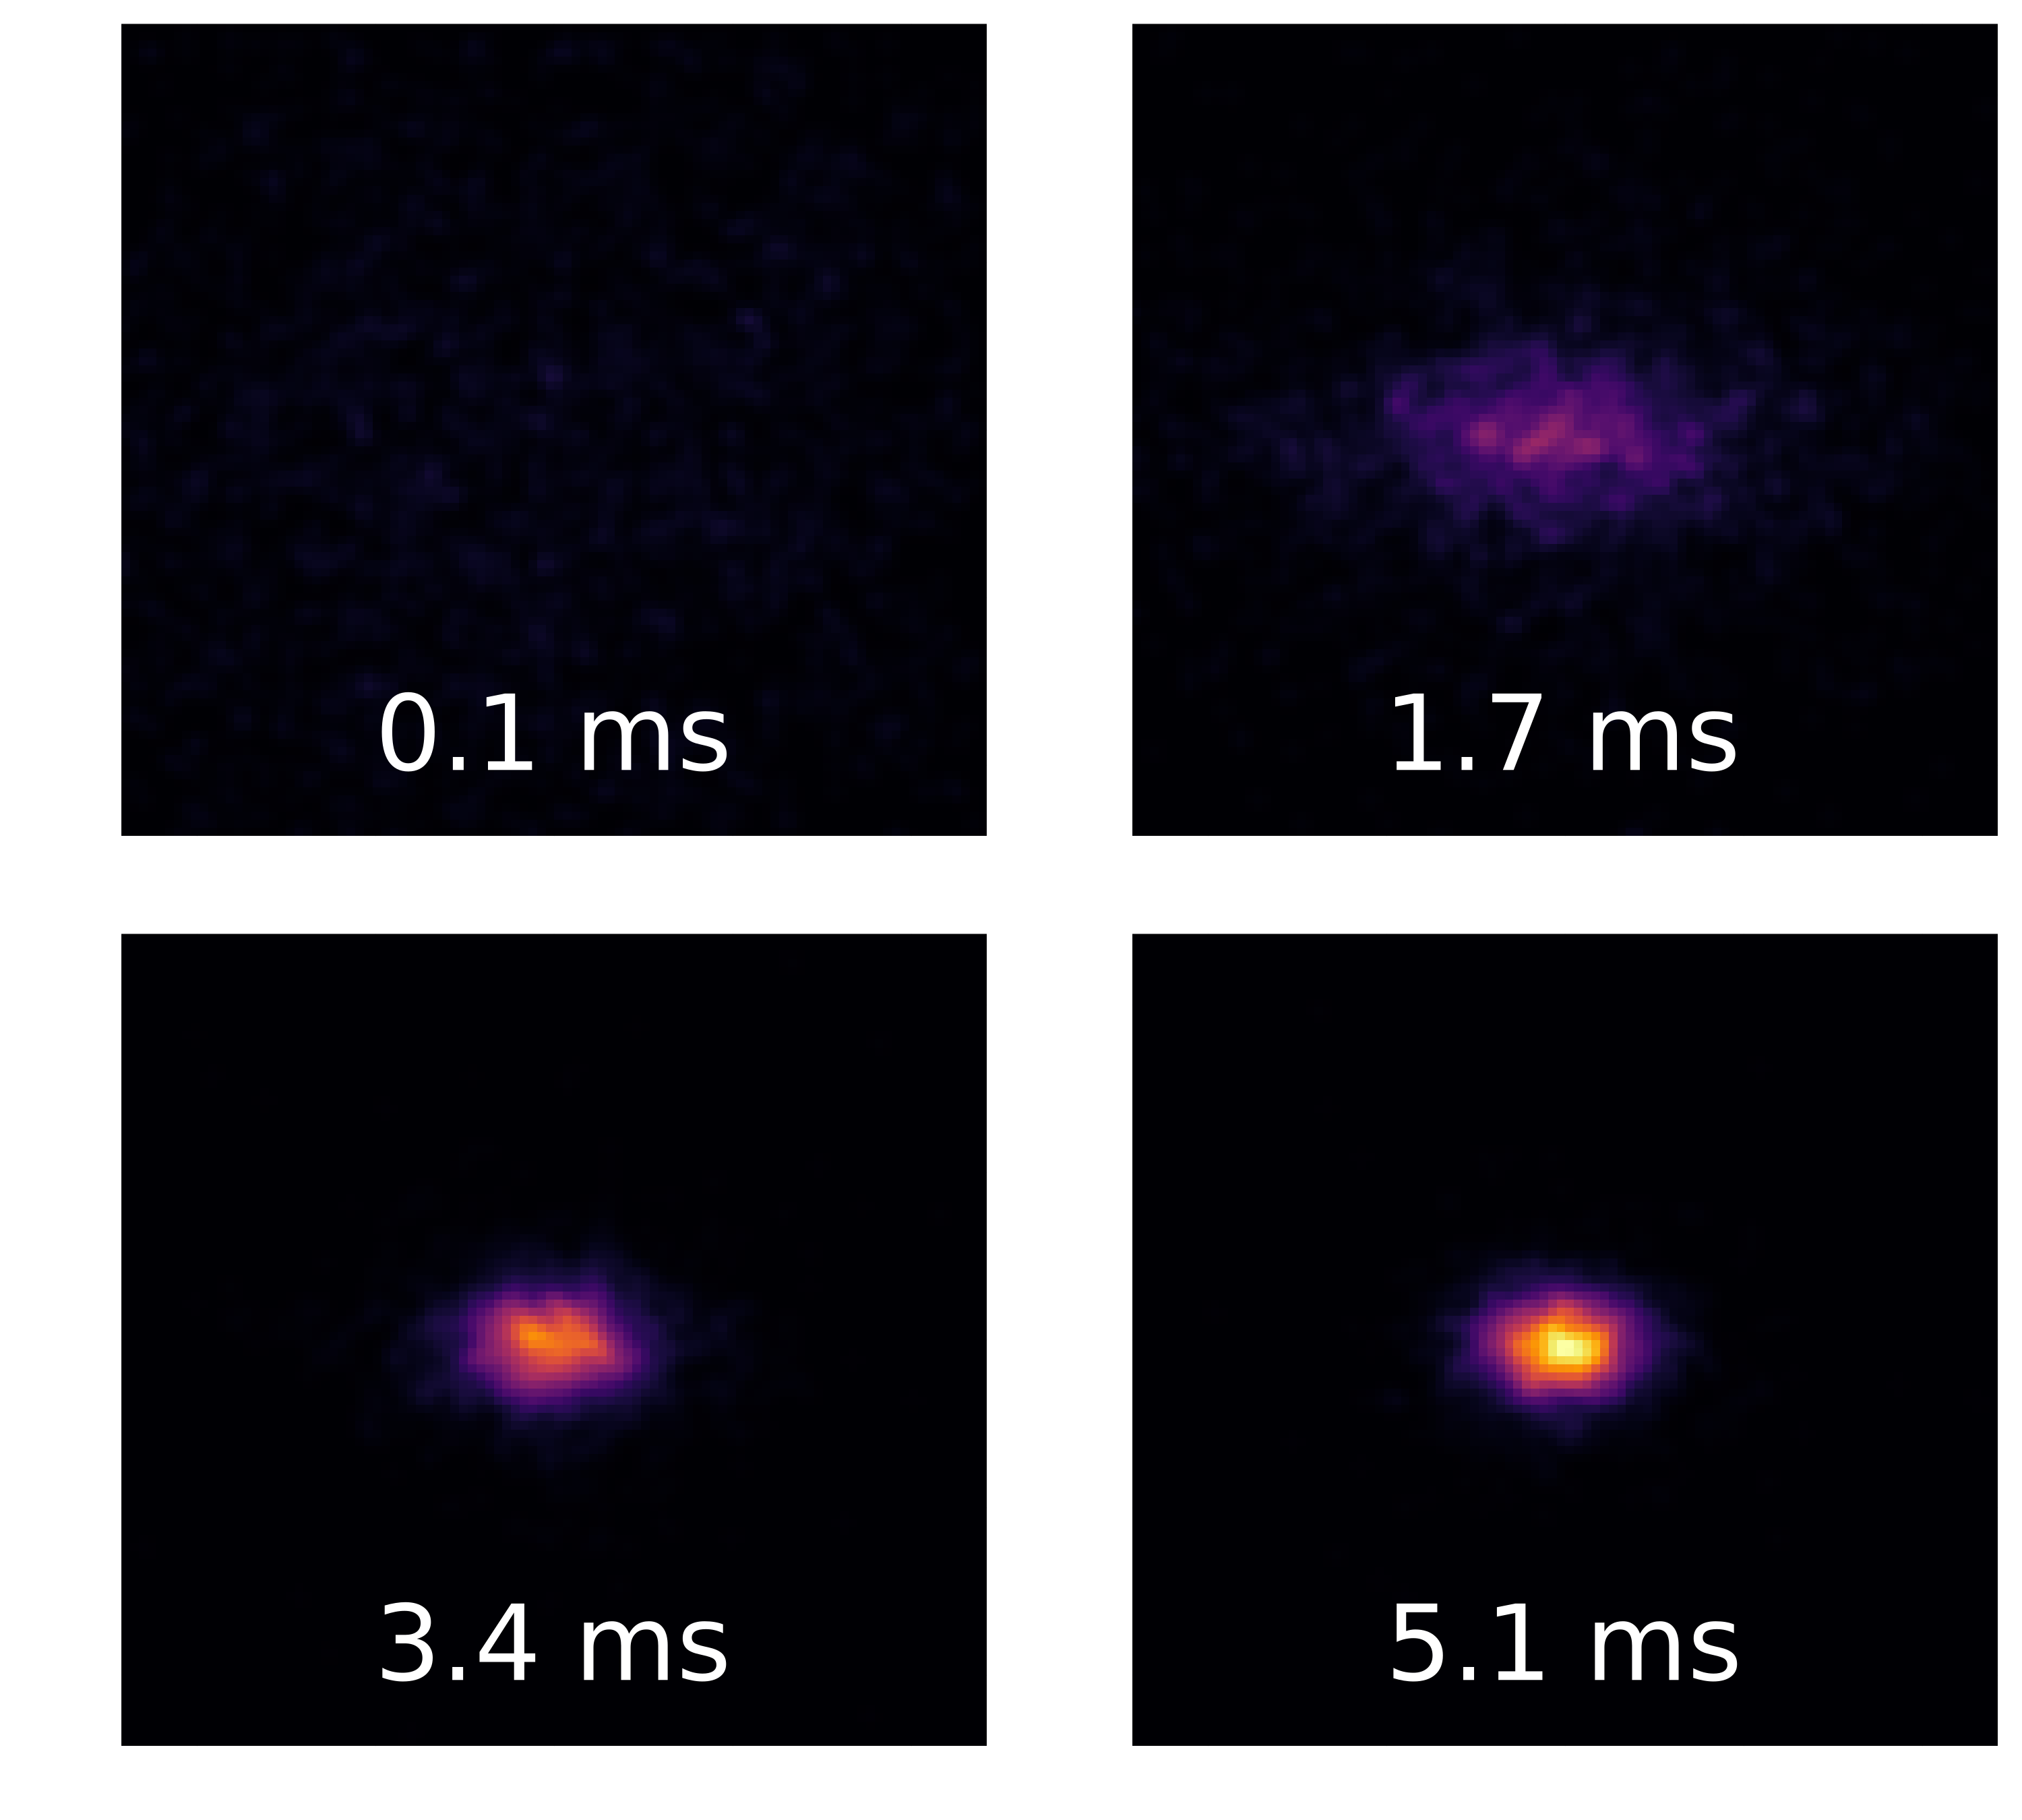

In [103]:
using ImageFiltering


ROI = 0.6 #16e-3*300/2 

img_duration = 2.0
n_pixels = 100

ts = [0.1,1.7,3.4,5.1]
filter = 1
cmax = 2
plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.02, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',clim=(0,8),legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-0.45,text(@sprintf("%.1f ms", t),:white,35))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(1000,900),dpi=300)
savefig(joinpath("C:\\Users\\halla\\OneDrive\\Desktop", "simulated_images.png"))
    
plot!()

In [4]:
# diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-3, n_particles=20, 
#                                             ramp_time=1e-6, temp = 1e-4, diameter=80e-6)
diffusion_constants = 0.0:0.5:4
sizes = []
temps = []
results_list = []
for diffusion_constant in diffusion_constants
    @printf("diffusion constant = %.2f \n", diffusion_constant)
    blue_MOT_params.diffusion_constant = diffusion_constant
    sequence = [blue_MOT_params]
    durations = [5e-3]
    generate_sequence!(sequence, durations)

    @time results = simulate_particles_constant_diffusion(package, package_A, sequence, variable_budget=true);
    size_fit, error = bootstrap_size_fit(results; iter=100)
    temp, temp_error = bootstrap_temperature_fit(results; iter=100, range=0.5, n_grids=30)
    push!(results_list, results)
    push!(sizes, size_fit)
    push!(temps, temp)

    @printf("goodness = %.2f \n",  goodness(blue_MOT_params.t_end, results))
end

diffusion constant = 0.00 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


114.961739 seconds (25.04 M allocations: 1.596 GiB, 0.66% gc time, 233.68% compilation time: <1% of which was recompilation)
Survival: 99 / 100
goodness = 0.60 
diffusion constant = 0.50 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


101.828594 seconds (165.16 k allocations: 34.481 MiB)
Survival: 98 / 100
goodness = 0.61 
diffusion constant = 1.00 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


102.397579 seconds (166.04 k allocations: 34.553 MiB)
Survival: 97 / 100
goodness = 0.57 
diffusion constant = 1.50 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:41

101.322053 seconds (165.09 k allocations: 34.537 MiB)


Survival: 100 / 100
goodness = 0.51 
diffusion constant = 2.00 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


 99.461206 seconds (164.13 k allocations: 34.449 MiB)
Survival: 99 / 100
goodness = 0.42 
diffusion constant = 2.50 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


 93.576624 seconds (166.05 k allocations: 34.150 MiB)
Survival: 79 / 100
goodness = 0.25 
diffusion constant = 3.00 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26                                                                               


 86.821093 seconds (166.80 k allocations: 33.985 MiB, 0.01% gc time)
Survival: 69 / 100
goodness = 0.12 
diffusion constant = 3.50 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


 67.348416 seconds (161.40 k allocations: 32.754 MiB)
Survival: 35 / 100
goodness = 0.05 
diffusion constant = 4.00 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


 53.965758 seconds (161.93 k allocations: 32.191 MiB)


LoadError: DomainError with -0.00025219243189407995:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

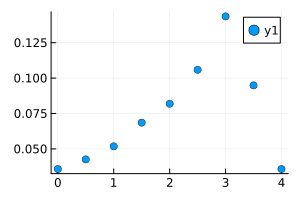

In [5]:
scatter(diffusion_constants, sizes, size=[300,200])

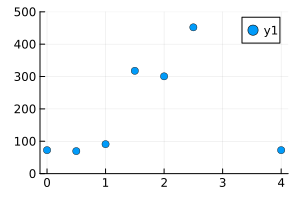

In [7]:
scatter(diffusion_constants, temps, size=[300,200],ylim=[0,500])

In [82]:
diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-3, n_particles=20, 
                                            ramp_time=1e-6, temp = 2e-4, diameter=80e-6)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


1.9639929308909423

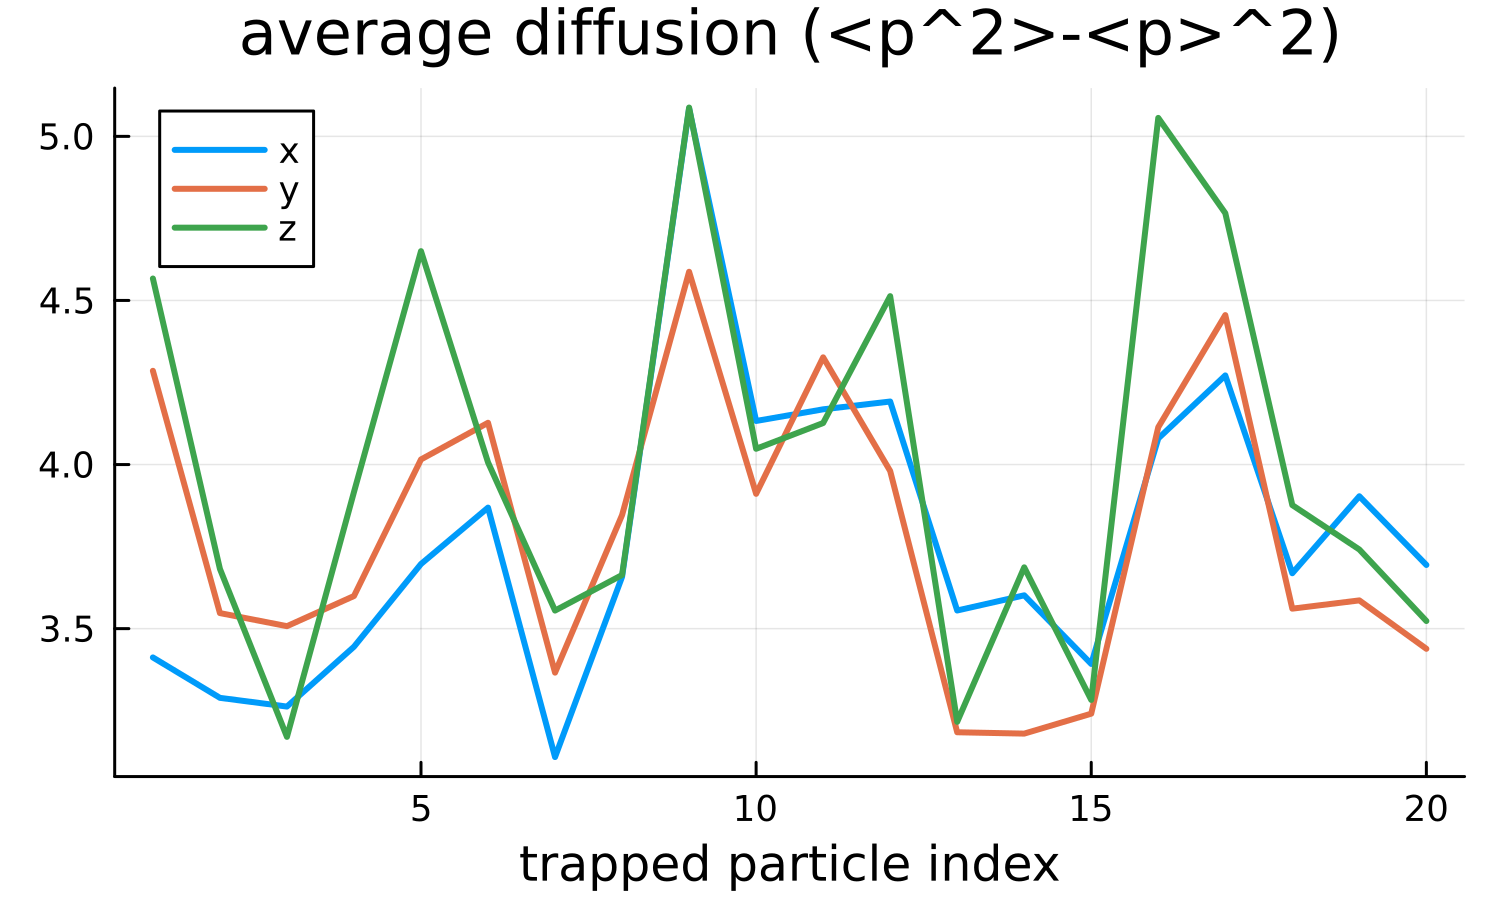

In [83]:
plot!()

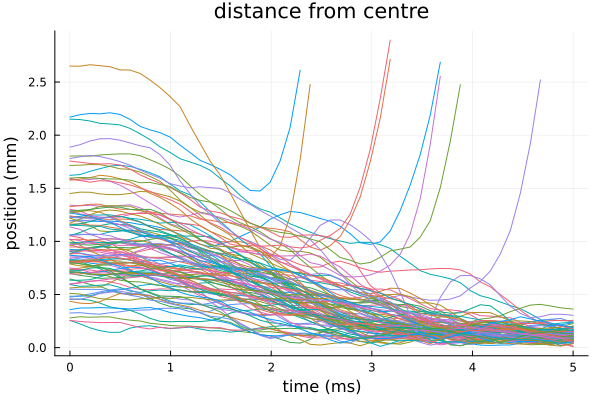

In [28]:
plot_all_trajectories(results, "all")
plot!()

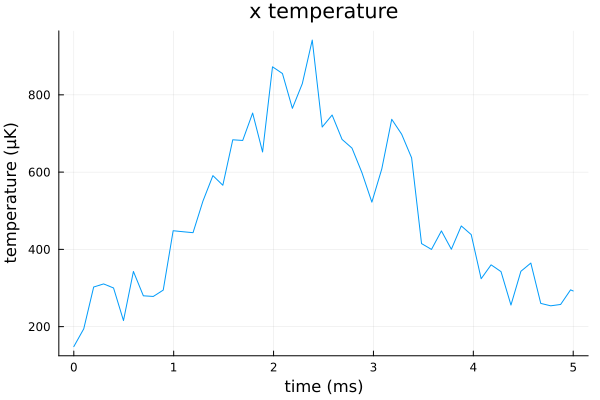

In [58]:
plot_temperature(results, "x")
plot!()

In [54]:
size_fit, error = bootstrap_size_fit(results; iter=100)

(0.0665125666954794, 0.008269062287981322)

In [56]:
t_end = 5e-3
temp, temp_error = bootstrap_temperature_fit(results; iter=100, range=0.5, n_grids=30)

(260.8920393127051, 84.50789425430314)

228.01350718695315
242.05569597883067


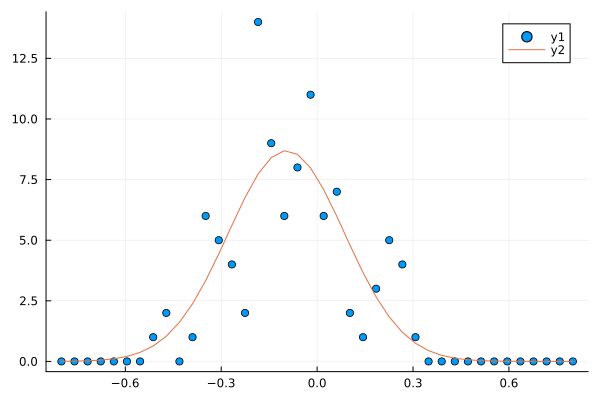

In [77]:
n_values = 100
t_end = 5e-3

sizes = []
x_grid = collect(LinRange(-0.8, 0.8, 40))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived(t_end, results1.times)

xs = [results1.x_velocities[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

# println(fit.param[2])
# println(plot_size(results1, "x")[2][end])
println(m * fit.param[2]^2 /k_B *1e6)

println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))